# 05 - Advanced Models

Modelos avançados (e.g., Gradient Boosting, XGBoost/LightGBM se disponível) e comparação.



In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, mean_squared_error

import sys
import os

# Adiciona o diretório raiz do projeto ao PYTHONPATH
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from huggingface_hub import hf_hub_download
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Selected features helper
def load_selected_features(df: pd.DataFrame) -> list:
    p = Path('reports/eda/selected_features.csv')
    if p.exists():
        try:
            feats = pd.read_csv(p).iloc[:,0].dropna().astype(str).tolist()
            feats = [c for c in feats if c in df.columns and c != 'quality']
            if feats:
                return feats
        except Exception:
            pass
    return [c for c in df.select_dtypes(include=[np.number]).columns if c != 'quality']

# Load processed df helper
def load_processed_df():
    HF_TOKEN = os.getenv('HF_TOKEN', None)
    HF_PROCESSED_REPO = os.getenv('HF_PROCESSED_REPO', 'henriquebap/wine-ml-processed')
    try:
        df_path = hf_hub_download(repo_id=HF_PROCESSED_REPO, filename='processed/full.csv', repo_type='dataset', token=HF_TOKEN)
        df = pd.read_csv(df_path)
        print('✅ Dados processados carregados do HF Hub')
    except Exception as e:
        print('⚠️ Fallback para dados locais:', e)
        proc = Path.cwd().parent / 'data' / 'processed' / 'df_capped.csv'
        if proc.exists():
            df = pd.read_csv(proc)
        else:
            raise FileNotFoundError('df_capped.csv não encontrado localmente nem no Hub')
    return df

/Users/henriquebap/Pessoal/Personal - Projects/Wine_MLProject/wine-ml-app/.venv311/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Optional imports if available
try:
    from xgboost import XGBRegressor
    has_xgb = True
except Exception:
    has_xgb = False
    print("⚠️ XGBoost não instalado. As células de XGB serão ignoradas.")

# Dados processados + features selecionadas
_df = load_processed_df()
FEATURES = load_selected_features(_df)
X = _df[FEATURES]
y = _df["quality"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "GBR": GradientBoostingRegressor(random_state=42),
}
if has_xgb:
    models["XGB"] = XGBRegressor(n_estimators=400, max_depth=6, learning_rate=0.05, subsample=0.9, colsample_bytree=0.8, random_state=42)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = []
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    results.append({
        "model": name,
        "rmse_mean": -scores.mean(),
        "rmse_std": scores.std(),
    })

pd.DataFrame(results).sort_values("rmse_mean")


✅ Dados processados carregados do HF Hub


,model,rmse_mean,rmse_std
0,GBR,0.632872,0.048447
1,XGB,0.654416,0.051908


### XGBOOST

In [3]:
# Tenta importar o XGBRegressor, mas se falhar (por erro de libomp ou outro), exibe uma mensagem amigável e pula o ajuste.
try:
    from xgboost import XGBRegressor
    xgb_available = True
except Exception as e:
    print(
        "XGBoost não está disponível ou não pôde ser carregado corretamente.\n"
        "Se você está no MacOS e vê um erro relacionado ao 'libomp', tente o seguinte:\n"
        "1. Instale o runtime OpenMP:\n    brew install libomp\n"
        "2. Ative seu ambiente virtual Python (se estiver usando):\n    source .venv311/bin/activate\n"
        "3. Reinicie seu ambiente Python (feche e reabra o Jupyter Notebook ou reinicie o kernel).\n"
        "4. Se o erro persistir, verifique se as variáveis de ambiente estão corretas:\n    export LDFLAGS=\"-L/opt/homebrew/opt/libomp/lib\"\n    export CPPFLAGS=\"-I/opt/homebrew/opt/libomp/include\"\n   (Adicione ao seu ~/.zshrc)\n"
        "5. Confirme que o Python do Jupyter é o mesmo do seu venv.\n"
        f"Erro original:\n{e}\n"
        "Pulando ajuste do XGBoost."
    )
    xgb_available = False

if xgb_available:
    xgb = XGBRegressor(objective="reg:squarederror", random_state=42)

    param_grid = {
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [3, 5, 6, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1],
        'colsample_bytree': [0.8, 1]
    }

    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(x_train, y_train)
else:
    grid_search = None  # Para evitar erro em células seguintes

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


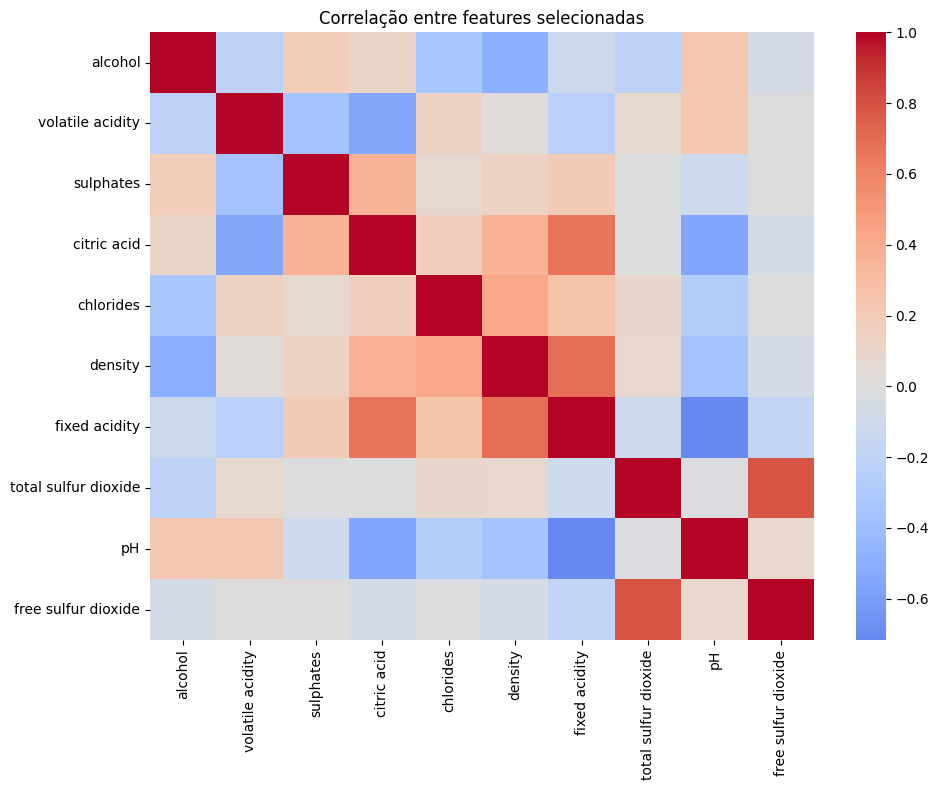

Figuras exportadas para: reports/viz


In [5]:
# Correlation heatmap (selected features)
plt.figure(figsize=(10,8))
corr_df = _df[FEATURES].corr()
sns.heatmap(corr_df, cmap='coolwarm', center=0, annot=False, fmt='.2f')
plt.title('Correlação entre features selecionadas')
plt.tight_layout()
plt.show()

# Export figuras
from pathlib import Path
out_dir = Path('reports/viz'); out_dir.mkdir(parents=True, exist_ok=True)
print('Figuras exportadas para:', out_dir)


In [6]:
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor score:", grid_search.best_score_)

Melhores parâmetros: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.8}
Melhor score: -0.3655881404876709


In [7]:
xgb = XGBRegressor(**grid_search.best_params_, random_state=42)

In [8]:
xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [9]:
y_pred = xgb.predict(x_test)

In [10]:
rmse_xgb = root_mean_squared_error(y_test, y_pred)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred)

In [11]:
print('RMSE:', rmse_xgb)
print('MAPE:', mape_xgb)

RMSE: 0.7031701803207397
MAPE: 0.10280641913414001


### Gradient Boosting

In [12]:
gbr = GradientBoostingRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

grid = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid.fit(x_train, y_train)

print("Melhores parâmetros:", grid.best_params_)
print("Melhor score:", grid.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Melhores parâmetros: {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 500, 'subsample': 0.8}
Melhor score: -0.36023288100200035


In [13]:
gbr = GradientBoostingRegressor(**grid.best_params_, random_state=42)

In [14]:
gbr.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_features='sqrt',
                          n_estimators=500, random_state=42, subsample=0.8)

In [15]:
y_pred = gbr.predict(x_test)

In [16]:
rmse_gbr = root_mean_squared_error(y_test, y_pred)
mape_gbr = mean_absolute_percentage_error(y_test, y_pred)

In [17]:
print('RMSE:', rmse_gbr)
print('MAPE:', mape_gbr)

RMSE: 0.700706960835349
MAPE: 0.10216078150025519


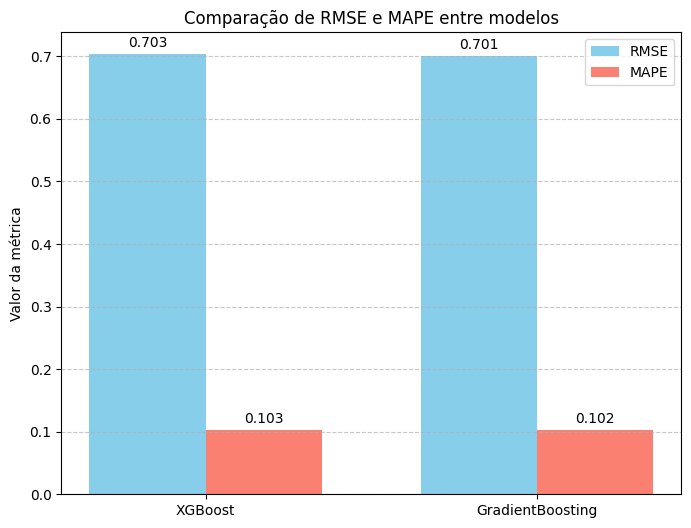

In [18]:
modelos = ["XGBoost", "GradientBoosting"]

rmse = [rmse_xgb, rmse_gbr]
mape = [mape_xgb, mape_gbr]

x = np.arange(len(modelos))  # posições dos modelos
largura = 0.35  # largura das barras

fig, ax = plt.subplots(figsize=(8, 6))

# Barras
barras_rmse = ax.bar(x - largura/2, rmse, largura, label="RMSE", color="skyblue")
barras_mape = ax.bar(x + largura/2, mape, largura, label="MAPE", color="salmon")

# Adiciona rótulos em cima das barras
ax.bar_label(barras_rmse, fmt="%.3f", padding=3)
ax.bar_label(barras_mape, fmt="%.3f", padding=3)

# Ajustes visuais
ax.set_ylabel("Valor da métrica")
ax.set_title("Comparação de RMSE e MAPE entre modelos")
ax.set_xticks(x)
ax.set_xticklabels(modelos)
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()